In [ ]:
import pandas as pd 

In [4]:
# Load the dataset
df = pd.read_csv('youtube.csv')

In [ ]:
# Display the first few rows and basic info
df.head(), df.info()

In [ ]:
%pip install textblob

In [16]:
# Convert dates to datetime format
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%d/%m/%Y', errors='coerce')

In [17]:
# Drop duplicates and unnecessary columns
df_cleaned = df.drop(columns=['index', 'video_error_or_removed'])
df_cleaned = df_cleaned.drop_duplicates()

In [19]:
# Define category ID to name mapping (sample from YouTube Data API)
category_map = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism"
}
df_cleaned['category'] = df_cleaned['category_id'].map(category_map)

In [ ]:
# Display cleaned dataset info
df_cleaned.info(), df_cleaned[['trending_date', 'publish_date', 'category']].head()

In [21]:
from textblob import TextBlob

In [22]:
# Function to compute sentiment polarity
def get_sentiment(text):
    if pd.isnull(text):
        return 'neutral'
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

In [23]:
# Apply sentiment analysis
df_cleaned['title_sentiment'] = df_cleaned['title'].apply(get_sentiment)
df_cleaned['tags_sentiment'] = df_cleaned['tags'].apply(get_sentiment)

In [24]:
import sqlite3

In [25]:
# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')
df_cleaned.to_sql('youtube_trending', conn, index=False, if_exists='replace')

161251

In [26]:
# SQL Query: Average views by category, ranked
query = """
SELECT category, 
       COUNT(*) AS video_count,
       ROUND(AVG(views), 2) AS avg_views
FROM youtube_trending
WHERE category IS NOT NULL
GROUP BY category
ORDER BY avg_views DESC;
"""


In [ ]:
# Run the query and view result
avg_views_by_category = pd.read_sql_query(query, conn)
print(avg_views_by_category)

In [28]:
import matplotlib.pyplot as plt

In [29]:
import seaborn as sns

In [30]:
# Compute trending duration per video
df_trend_duration = df_cleaned.groupby(['video_id', 'category']).agg(
    trending_start=('trending_date', 'min'),
    trending_end=('trending_date', 'max'),
    views_total=('views', 'max')
).reset_index()

df_trend_duration['trending_days'] = (df_trend_duration['trending_end'] - df_trend_duration['trending_start']).dt.days + 1

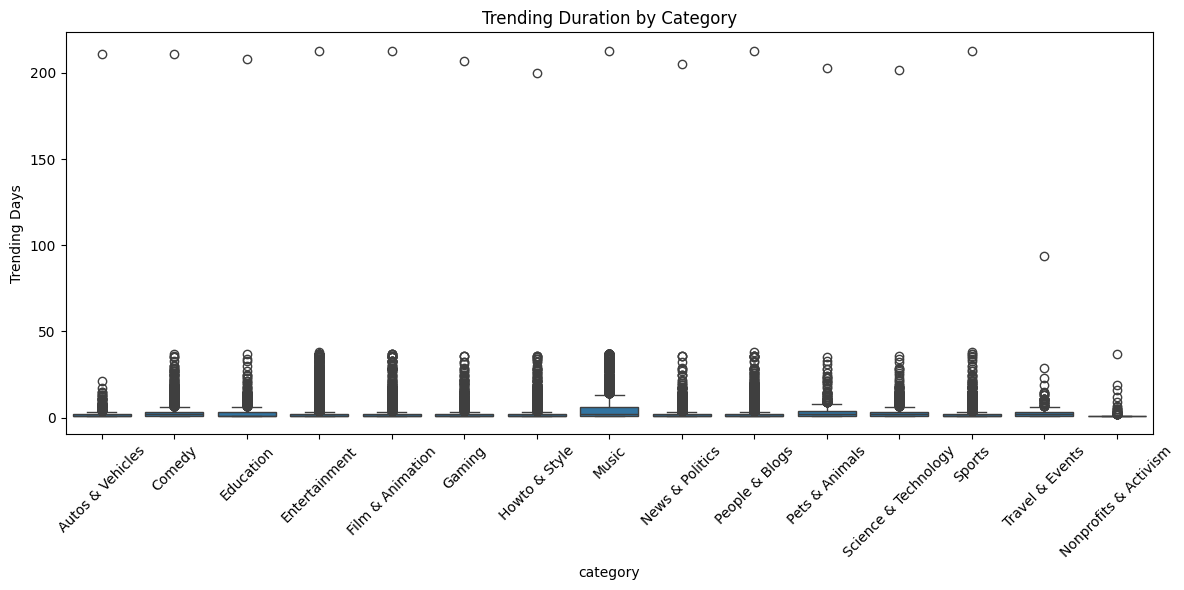

In [31]:
# Plot trending duration by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_trend_duration, x='category', y='trending_days')
plt.xticks(rotation=45)
plt.title('Trending Duration by Category')
plt.ylabel('Trending Days')
plt.tight_layout()
plt.show()

In [32]:
df_cleaned.to_csv("cleaned_youtube_trending.csv", index=False)